In [23]:
# 1. Download the file as a ZIP from the UCI repository
print("Downloading data from UCI archive...")
!wget -O smsspamcollection.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

# 2. Unzip the file to get 'SMSSpamCollection'
import zipfile
import os

local_zip_path = 'smsspamcollection.zip'
local_file_path = 'SMSSpamCollection'

if os.path.exists(local_zip_path):
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Data extracted successfully.")
else:
    print("Error: ZIP file not found after download attempt.")

--2025-10-06 06:18:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  1.06MB/s    in 0.2s    

2025-10-06 06:18:16 (1.06 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Data extracted successfully.


In [24]:
#Data preparation and cleaning
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ====================================================================
# 1. NLTK Resource Downloads
# ====================================================================
print("\nChecking/Downloading NLTK Resources...")
required_nltk_resources = ['stopwords', 'wordnet', 'punkt', 'omw-1.4']

for resource in required_nltk_resources:
    try:
        nltk.data.find(resource)
    except LookupError:
        print(f"Downloading '{resource}'...")
        nltk.download(resource)
print("NLTK Resources ready.")

# ====================================================================
# 2. Data Loading & Initial Cleaning
# ====================================================================

FILE_NAME = 'SMSSpamCollection'
SUCCESS = False
df = pd.DataFrame()

try:
    # Load the file we just unzipped (tab-separated, no header)
    df = pd.read_csv(FILE_NAME, sep='\t', encoding='latin-1', header=None)
    df.columns = ['label', 'message']

    if len(df) == 5572:
        SUCCESS = True
        print(f"\nSUCCESS: Full dataset loaded. Rows: {len(df)}")
    else:
        raise Exception(f"File loaded, but row count is incorrect ({len(df)} rows).")

except Exception as e:
    print(f"\nFATAL ERROR: Could not load full data. Error: {e}")
    # Fallback only for code completion, though results are meaningless
    data = {'label': ['ham', 'spam', 'ham'],
            'message': ['Go until jurong point, crazy..', 'SIX chances to win CASH!', 'I have a meeting tomorrow.']}
    df = pd.DataFrame(data)

# --- Continue Cleaning ---
df.dropna(inplace=True)
rows_before_dup = len(df)
df.drop_duplicates(inplace=True)
print(f"Duplicates handled. Rows removed: {rows_before_dup - len(df)}")
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
print("\n--- Class Distribution ---")
print(df['label'].value_counts())

# --- Text Preprocessing Function ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|<.*?>|\d+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', punctuations))
    tokens = word_tokenize(text)
    processed_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]
    return " ".join(processed_tokens)

# Apply Preprocessing
df['clean_message'] = df['message'].apply(preprocess_text)
print("\nData Cleaning and Preparation Steps Complete.")


Checking/Downloading NLTK Resources...
NLTK Resources ready.

SUCCESS: Full dataset loaded. Rows: 5572
Duplicates handled. Rows removed: 403

--- Class Distribution ---
label
0    4516
1     653
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Data Cleaning and Preparation Steps Complete.


In [26]:
#Feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

X = df['clean_message']
y = df['label']

print("\n--- 3. Feature Extraction & Model Training ---")

# --- Feature Extraction & Splitting ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dataset split (stratified) and TF-IDF features created. Train Shape: {X_train_tfidf.shape}")

# --- Model Training (Deliverable) ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("1. Naive Bayes Model Trained.")

lr_model = LogisticRegression(C=10, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)
print("2. Logistic Regression Model Trained.")


--- 3. Feature Extraction & Model Training ---
Dataset split (stratified) and TF-IDF features created. Train Shape: (3618, 6370)
1. Naive Bayes Model Trained.
2. Logistic Regression Model Trained.



--- 4. Evaluation ---

--- Model Comparison Table ---
| Model               |   Accuracy |   Precision |   Recall |   F1-score |
|:--------------------|-----------:|------------:|---------:|-----------:|
| Logistic Regression |   0.971631 |    0.969136 | 0.80102  |   0.877095 |
| Naive Bayes         |   0.958736 |    1        | 0.673469 |   0.804878 |


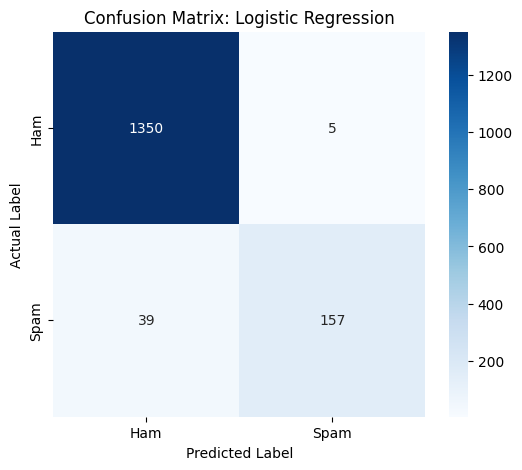

In [27]:
#Evaluation and REporting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Needed here for the results DataFrame

def evaluate_model(model, X_test_features, y_true, model_name):
    y_pred = model.predict(X_test_features)
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }
    return y_pred, metrics

print("\n--- 4. Evaluation ---")

# Evaluate and compare models
nb_pred, nb_metrics = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")
lr_pred, lr_metrics = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")
results_df = pd.DataFrame([nb_metrics, lr_metrics])

print("\n--- Model Comparison Table ---")
print(results_df.sort_values(by='F1-score', ascending=False).to_markdown(index=False))

# --- Visualization: Confusion Matrix (Deliverable: Using the Logistic Regression model) ---
cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix: Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [28]:
#Reusable script and saving
import joblib

def predict_message(message, vectorizer, model):
    """Processes a raw message and predicts if it's spam or ham."""
    # Uses the preprocess_text function defined in Cell 1
    clean_msg = preprocess_text(message)
    msg_features = vectorizer.transform([clean_msg])
    prediction = model.predict(msg_features)[0]
    return "SPAM" if prediction == 1 else "HAM"

# --- Test Pipeline ---
print("\n--- 5. Reusable Script Test ---")
sample_messages = [
    "Congratulations! Click here to claim your cash prize!", # Spam
    "Did you remember to bring the documents for our meeting?", # Ham
]
for msg in sample_messages:
    prediction = predict_message(msg, tfidf_vectorizer, lr_model)
    print(f"Message: '{msg[:40]}...' -> Prediction: {prediction}")

# --- Save trained models for future use (Deliverable) ---
joblib.dump(lr_model, 'best_spam_detector_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("\n✅ Project Complete! Model and Vectorizer saved.")


--- 5. Reusable Script Test ---
Message: 'Congratulations! Click here to claim you...' -> Prediction: SPAM
Message: 'Did you remember to bring the documents ...' -> Prediction: HAM

✅ Project Complete! Model and Vectorizer saved.
